
## 목차
1. 환경 설정 및 필요한 라이브러리 불러오기
- PyTorch, torchvision 등 필요한 라이브러리 import
- CUDA 사용 가능 여부 확인 및 device 설정

2. COCO 데이터셋 준비
- COCO 데이터셋 다운로드 및 경로 설정
- COCO API 설치 및 사용 방법 소개
- 데이터셋 클래스 정의 (CocoDetection 활용)
- DataLoader 설정

3. RetinaNet-ResNeXt50 모델 구현
- ResNeXt50 백본 네트워크 정의
- FPN (Feature Pyramid Network) 구현
- RetinaNet 헤드 (분류 및 박스 회귀) 구현
- Anchor 생성기 구현
- 전체 RetinaNet-ResNeXt50 모델 조립

4. 손실 함수 정의
- Focal Loss 구현
- Smooth L1 Loss 구현
- 전체 손실 함수 조합

5. 학습 루프 구현
- 옵티마이저 설정 (예: Adam)
- 학습률 스케줄러 설정
- 에폭 단위 학습 함수 구현
- 검증 함수 구현

6. 모델 학습 실행

## CPU 모델 및 GPU 모델 확인

In [2]:
#현재 CPU모델과 GPU모델 확인
!cat /proc/cpuinfo | grep "model name" | uniq
!nvidia-smi

model name	: 13th Gen Intel(R) Core(TM) i7-13700KF
Tue Oct 15 20:54:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
|  0%   38C    P8             35W /  450W |    2752MiB /  24564MiB |     29%      Default |
|                                         |                        |                  N/A

## import 및 패키지 다운

In [3]:
'''
!pip install torch torchvision pycocotools pillow matplotlib
'''

'\n!pip install torch torchvision pycocotools pillow matplotlib\n'

## 모델 파라미터 설정

In [4]:
config = {'print_inter' : 5,
          'batch_size'  : 4,
          'worker'      : 2,
          'epochs'      : 1,
          'momentum'    : 0.9,
          'lr_decay'    : 0.0005,
          'SGD_lr'      : 0.01,
          'Adam_lr'     : 0.001,
          'notebook_name': "ver2_Local_CPU"
          }

## COCO 데이터셋 준비

In [5]:
#Colab에서 사용시 필요 (로컬시 주석처리)

'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [6]:
# coco 데이터셋 다운로드 (구글드라이브) (colab에서 사용시 사용)
# 필요시 주석 제거

'''
!wget -nc http://images.cocodataset.org/zips/train2017.zip -P /content/drive/MyDrive/
!wget -nc http://images.cocodataset.org/zips/test2017.zip -P /content/drive/MyDrive/
!wget -nc http://images.cocodataset.org/zips/val2017.zip -P /content/drive/MyDrive/
!wget -nc http://images.cocodataset.org/zips/unlabeled2017.zip -P /content/drive/MyDrive/
'''

'''
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/drive/MyDrive/
!wget -nc http://images.cocodataset.org/annotations/image_info_test2017.zip -P /content/drive/MyDrive/
!wget -nc http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip -P /content/drive/MyDrive/
!wget -nc http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip -P /content/drive/MyDrive/
'''

'''
!wget -nc http://images.cocodataset.org/zips/train2017.zip -P ./data
!wget -nc http://images.cocodataset.org/zips/test2017.zip -P ./data
!wget -nc http://images.cocodataset.org/zips/val2017.zip -P ./data
!wget -nc http://images.cocodataset.org/zips/unlabeled2017.zip -P ./data
'''

'''
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P ./data
!wget -nc http://images.cocodataset.org/annotations/image_info_test2017.zip -P ./data
!wget -nc http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip -P ./data
!wget -nc http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip -P ./data
'''

'\n!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P ./data\n!wget -nc http://images.cocodataset.org/annotations/image_info_test2017.zip -P ./data\n!wget -nc http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip -P ./data\n!wget -nc http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip -P ./data\n'

In [7]:
# coco 및 모든 하위 data 삭제

# import shutil
# shutil.rmtree("/content/coco")

In [8]:
# if you have zip files in your drive, and not unzipped yet
# if you have unzipped directories of all of these in your drive, SKIP THIS CELL

'''
!sudo apt install pv
n_files = !unzip -l /content/drive/MyDrive/train2017.zip | grep .jpg | wc -l
!unzip -o /content/drive/MyDrive/train2017.zip -d coco | pv -l -s {n_files[0]} > /dev/null
!unzip -o /content/drive/MyDrive/val2017.zip -d coco | pv -l -s {n_files[0]} > /dev/null
# 드라이브에 압축풀음 (초기 1회만 사용) (필요시 주석제거)

!unzip -n /content/drive/MyDrive/annotations_trainval2017.zip -d /content/drive/MyDrive/annotations_trainval2017
!unzip -n /content/drive/MyDrive/test2017.zip -d /content/drive/MyDrive/test2017
!unzip -n /content/drive/MyDrive/image_info_test2017.zip -d /content/drive/MyDrive/image_info_test2017
'''

# 로컬에서 압축해제시 사용 (가능하면 반디집 추천)
'''
!unzip -n ./data/train2017.zip -d ./data/coco/train2017
!unzip -n ./data/test2017.zip -d ./data/coco/test2017
!unzip -n ./data/val2017.zip -d ./data/coco/val2017
!unzip -n ./data/annotations_trainval2017.zip -d ./data/coco/annotations_trainval2017
!unzip -n ./data/image_info_test2017.zip -d ./data/coco/image_info_test2017
'''

'\n!unzip -n ./data/train2017.zip -d ./data/coco/train2017\n!unzip -n ./data/test2017.zip -d ./data/coco/test2017\n!unzip -n ./data/val2017.zip -d ./data/coco/val2017\n!unzip -n ./data/annotations_trainval2017.zip -d ./data/coco/annotations_trainval2017\n!unzip -n ./data/image_info_test2017.zip -d ./data/coco/image_info_test2017\n'

In [9]:
# path (colab 사용시 경로)
'''
trainset_path = "./data/coco/train2017/train2017"
trainAnno_path = "./content/coco/annotations_trainval2017/annotations/instances_train2017.json"

testset_path = "./content/coco/test2017"
testInfo_path = "./content/coco/image_info_test2017/annotations/image_info_test2017.json"

valset_path = "/content/coco/val2017"
valAnno_path = "/content/coco/annotations_trainval2017/annotations/instances_val2017.json"
'''

# path (local 환경에서 사용)

trainset_path = "./data/coco/train2017/train2017"
trainAnno_path = "./data/coco/annotations_trainval2017/annotations/instances_train2017.json"

testset_path = "./data/coco/test2017/test2017"
testInfo_path = "./data/coco/image_info_test2017/annotations/image_info_test2017.json"

valset_path = "./data/coco/val2017/val2017"
valAnno_path = "./data/coco/annotations_trainval2017/annotations/instances_val2017.json"

In [10]:
from pycocotools.coco import COCO
coco = COCO(trainAnno_path)
categories = coco.loadCats(coco.getCatIds())
print(categories, type(categories))

loading annotations into memory...
Done (t=6.36s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'n

In [11]:
category_id_to_index = {cat['id']: i for i, cat in enumerate(categories)}
coco_instance_category_names = ['__background__'] + [cat['name'] for cat in categories]

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
from PIL import Image
import numpy as np

class COCODataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None, set_name='val'):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.set_name = set_name

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = f"{self.root_dir}/{img_info['file_name']}"
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x+w, y+h])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id]),
            'orig_size': torch.as_tensor([img_info['height'], img_info['width']])
        }

        if self.transform:
            img, target = self.transform(img, target)

        return img, target

    def image_aspect_ratio(self, image_index):
        image = self.coco.loadImgs(self.ids[image_index])[0]
        return float(image['width']) / float(image['height'])

    def label_to_coco_label(self, label):
        return label  # COCO 데이터셋에서는 이미 COCO 레이블을 사용하므로 변환이 필요 없음

    @property
    def num_classes(self):
        return len(self.coco.getCatIds())

    @property
    def image_ids(self):
        return self.ids

In [13]:
from torch.nn.functional import pad

def collate_fn(batch):
    images = []
    targets = []
    max_width = 0
    max_height = 0

    for img, target in batch:
        max_width = max(max_width, img.shape[2])
        max_height = max(max_height, img.shape[1])

    for img, target in batch:
        pad_width = max_width - img.shape[2]
        pad_height = max_height - img.shape[1]
        padded_img = pad(img, (0, pad_width, 0, pad_height), mode='constant', value=0)
        images.append(padded_img)

        boxes = target['boxes']
        if boxes.numel() > 0:
            # 높이와 너비가 0인 박스 제거
            valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
            boxes = boxes[valid_boxes]
            target['labels'] = target['labels'][valid_boxes]

            if boxes.numel() > 0:
                # 박스 좌표 정규화 및 작은 값 추가
                boxes[:, [0, 2]] = boxes[:, [0, 2]] * (max_width / img.shape[2])
                boxes[:, [1, 3]] = boxes[:, [1, 3]] * (max_height / img.shape[1])
                boxes[:, 2:] += 1e-5  # 높이와 너비에 작은 값 추가
            else:
                # 유효한 박스가 없는 경우 더미 박스 추가
                boxes = torch.tensor([[0, 0, 1e-5, 1e-5]], dtype=torch.float32)
                target['labels'] = torch.tensor([0], dtype=torch.int64)
        else:
            # 박스가 없는 경우 더미 박스 추가
            boxes = torch.tensor([[0, 0, 1e-5, 1e-5]], dtype=torch.float32)
            target['labels'] = torch.tensor([0], dtype=torch.int64)

        target['boxes'] = boxes
        target['orig_size'] = torch.tensor([img.shape[1], img.shape[2]])
        target['size'] = torch.tensor([max_height, max_width])
        target['pad_size'] = torch.tensor([max_height, max_width])
        targets.append(target)

    images = torch.stack(images, dim=0)
    return images, targets

In [14]:
import torchvision.transforms as T
from torch.utils.data import Subset
import random


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = T.functional.to_tensor(image)
        return image, target

class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = T.functional.normalize(image, mean=self.mean, std=self.std)
        return image, target

# 데이터 변환
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.47004986, 0.44683833, 0.40762289], std=[0.24388725, 0.2390123, 0.24204847])
])
# COCO mean: [0.47004986 0.44683833 0.40762289]
# COCO std: [0.24388725 0.2390123  0.24204847]

# 데이터셋 생성
train_dataset = COCODataset(root_dir=trainset_path,
                            annotation_file=trainAnno_path,
                            transform=transform)

test_dataset = COCODataset(root_dir=testset_path,
                           annotation_file=testInfo_path,
                           transform=transform)

val_dataset = COCODataset(root_dir=valset_path,
                          annotation_file=valAnno_path,
                          transform=transform)
# 1000개의 인덱스를 무작위로 선택
indices = random.sample(range(len(train_dataset)), 100)

# 선택된 인덱스로 서브셋 생성
subset = Subset(train_dataset, indices)


# train 데이터로더 생성
train_loader = DataLoader(subset,
                          batch_size=config['batch_size'],
                          shuffle=True,
                          num_workers=config['worker'],
                          collate_fn=collate_fn)
# test 데이터로더
test_loader = DataLoader(test_dataset,
                         batch_size=config['batch_size'],
                         shuffle=False,
                         num_workers=config['worker'],
                         collate_fn=collate_fn)
# valid 데이터로더
val_loader = DataLoader(val_dataset,
                         batch_size=config['batch_size'],
                         shuffle=False,
                         num_workers=config['worker'],
                         collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.87s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


## trainloader 이미지 살펴보기


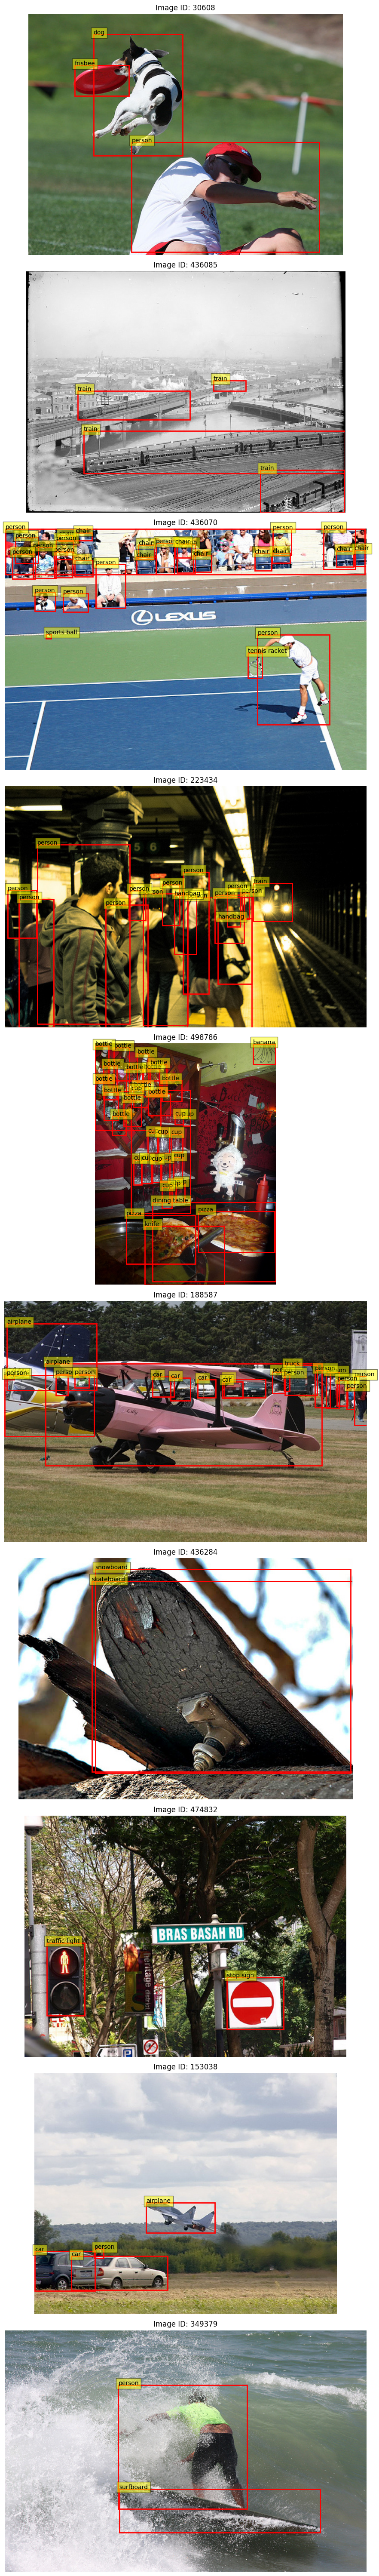

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import torchvision.transforms.functional as F

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_batch(dataloader, num_images=10):
    mean = [0.47004986, 0.44683833, 0.40762289]
    std = [0.24388725, 0.2390123, 0.24204847]

    plt.figure(figsize=(20, 6 * num_images))
    for i in range(num_images):
        images, targets = next(iter(dataloader))

        idx = random.randint(0, images.shape[0] - 1)
        image = images[idx]
        target = targets[idx]

        image = denormalize(image.clone(), mean, std)
        image = image.permute(1, 2, 0).numpy()

        orig_height, orig_width = target['orig_size']
        pad_height, pad_width = target['pad_size']

        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image[:orig_height, :orig_width])  # 원본 이미지 크기만큼만 표시
        plt.title(f"Image ID: {target['image_id'].item()}")

        for box, label_id in zip(target['boxes'], target['labels']):
            # 패딩을 고려하여 바운딩 박스 좌표 조정
            x1, y1, x2, y2 = box.numpy()
            x1 = x1 * orig_width / pad_width
            x2 = x2 * orig_width / pad_width
            y1 = y1 * orig_height / pad_height
            y2 = y2 * orig_height / pad_height

            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
            plt.gca().add_patch(rect)

            try:
                index = category_id_to_index[label_id.item()]
                class_name = coco_instance_category_names[index + 1]  # +1 because of background class
            except KeyError:
                class_name = f"Unknown ({label_id.item()})"
            plt.text(x1, y1, class_name, bbox=dict(facecolor='yellow', alpha=0.5))

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 데이터 시각화
visualize_batch(train_loader, num_images=10)

## 4. 모델 정의

In [16]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import List, Dict, Tuple
import math

from torchvision.ops import box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.ops.boxes import clip_boxes_to_image
from torchvision.ops.focal_loss import sigmoid_focal_loss

def _sum(x: List[Tensor]) -> Tensor:
    res = x[0]
    for i in x[1:]:
        res = res + i
    return res


# Define Matcher and BoxCoder classes manually
class Matcher:
    BELOW_LOW_THRESHOLD = -1
    BETWEEN_THRESHOLDS = -2

    def __init__(self, high_threshold, low_threshold, allow_low_quality_matches=False):
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold
        self.allow_low_quality_matches = allow_low_quality_matches

    def __call__(self, match_quality_matrix):
        matched_vals, matches = match_quality_matrix.max(dim=0)
        if self.allow_low_quality_matches:
            all_matches = matches.clone()
        else:
            all_matches = None

        below_low_threshold = matched_vals < self.low_threshold
        between_thresholds = (matched_vals >= self.low_threshold) & (matched_vals < self.high_threshold)

        matches[below_low_threshold] = self.BELOW_LOW_THRESHOLD
        matches[between_thresholds] = self.BETWEEN_THRESHOLDS

        if self.allow_low_quality_matches:
            self.set_low_quality_matches_(matches, all_matches, match_quality_matrix)

        return matches

    def set_low_quality_matches_(self, matches, all_matches, match_quality_matrix):
        highest_quality_foreach_gt, _ = match_quality_matrix.max(dim=1)
        gt_pred_pairs_of_highest_quality = torch.where(match_quality_matrix == highest_quality_foreach_gt[:, None])
        pred_inds_to_update = gt_pred_pairs_of_highest_quality[1]
        matches[pred_inds_to_update] = all_matches[pred_inds_to_update]

class BoxCoder:
    def __init__(self, weights, bbox_xform_clip=math.log(1000. / 16)):
        self.weights = weights
        self.bbox_xform_clip = bbox_xform_clip

    def encode(self, reference_boxes, proposals):
        wx, wy, ww, wh = self.weights
        targets = []
        for boxes_per_image, proposals_per_image in zip(reference_boxes, proposals):
            targets_per_image = self.encode_single(boxes_per_image, proposals_per_image)
            targets.append(targets_per_image)
        return targets

    def encode_single(self, reference_boxes, proposals):
        dtype = reference_boxes.dtype
        device = reference_boxes.device
        weights = torch.as_tensor(self.weights, dtype=dtype, device=device)
        targets = encode_boxes(reference_boxes, proposals, weights)
        return targets

    def decode(self, rel_codes, boxes):
        assert isinstance(boxes, (list, tuple))
        assert isinstance(rel_codes, torch.Tensor)
        boxes_per_image = [b.size(0) for b in boxes]
        concat_boxes = torch.cat(boxes, dim=0)
        box_sum = 0
        for val in boxes_per_image:
            box_sum += val
        pred_boxes = self.decode_single(
            rel_codes.reshape(box_sum, -1), concat_boxes
        )
        return pred_boxes.reshape(box_sum, -1, 4)

    def decode_single(self, rel_codes, boxes):
        boxes = boxes.to(rel_codes.dtype)
        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        ctr_x = boxes[:, 0] + 0.5 * widths
        ctr_y = boxes[:, 1] + 0.5 * heights

        wx, wy, ww, wh = self.weights
        dx = rel_codes[:, 0::4] / wx
        dy = rel_codes[:, 1::4] / wy
        dw = rel_codes[:, 2::4] / ww
        dh = rel_codes[:, 3::4] / wh

        dw = torch.clamp(dw, max=self.bbox_xform_clip)
        dh = torch.clamp(dh, max=self.bbox_xform_clip)

        pred_ctr_x = dx * widths[:, None] + ctr_x[:, None]
        pred_ctr_y = dy * heights[:, None] + ctr_y[:, None]
        pred_w = torch.exp(dw) * widths[:, None]
        pred_h = torch.exp(dh) * heights[:, None]

        pred_boxes = torch.zeros_like(rel_codes)
        pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
        pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
        pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
        pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h

        return pred_boxes


from torchvision.ops.focal_loss import sigmoid_focal_loss


__all__ = [
    "RetinaNet", "retinanet_resnet50_fpn"
]


def _sum(x: List[Tensor]) -> Tensor:
    res = x[0]
    for i in x[1:]:
        res = res + i
    return res


class RetinaNetHead(nn.Module):
    """
    A regression and classification head for use in RetinaNet.

    Args:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
        num_classes (int): number of classes to be predicted
    """

    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.classification_head = RetinaNetClassificationHead(in_channels, num_anchors, num_classes)
        self.regression_head = RetinaNetRegressionHead(in_channels, num_anchors)

    def compute_loss(self, targets, head_outputs, anchors, matched_idxs):
        # type: (List[Dict[str, Tensor]], Dict[str, Tensor], List[Tensor], List[Tensor]) -> Dict[str, Tensor]
        return {
            'classification': self.classification_head.compute_loss(targets, head_outputs, matched_idxs),
            'bbox_regression': self.regression_head.compute_loss(targets, head_outputs, anchors, matched_idxs),
        }

    def forward(self, x):
        # type: (List[Tensor]) -> Dict[str, Tensor]
        return {
            'cls_logits': self.classification_head(x),
            'bbox_regression': self.regression_head(x)
        }


class RetinaNetClassificationHead(nn.Module):
    """
    A classification head for use in RetinaNet.

    Args:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
        num_classes (int): number of classes to be predicted
    """

    def __init__(self, in_channels, num_anchors, num_classes, prior_probability=0.01):
        super().__init__()

        conv = []
        for _ in range(4):
            conv.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
            conv.append(nn.ReLU())
        self.conv = nn.Sequential(*conv)

        for layer in self.conv.children():
            if isinstance(layer, nn.Conv2d):
                torch.nn.init.normal_(layer.weight, std=0.01)
                torch.nn.init.constant_(layer.bias, 0)

        self.cls_logits = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
        torch.nn.init.normal_(self.cls_logits.weight, std=0.01)
        torch.nn.init.constant_(self.cls_logits.bias, -math.log((1 - prior_probability) / prior_probability))

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        # This is to fix using det_utils.Matcher.BETWEEN_THRESHOLDS in TorchScript.
        # TorchScript doesn't support class attributes.
        # https://github.com/pytorch/vision/pull/1697#issuecomment-630255584
        self.BETWEEN_THRESHOLDS = Matcher.BETWEEN_THRESHOLDS

    def compute_loss(self, targets, head_outputs, matched_idxs):
        # type: (List[Dict[str, Tensor]], Dict[str, Tensor], List[Tensor]) -> Tensor
        losses = []

        cls_logits = head_outputs['cls_logits']

        for targets_per_image, cls_logits_per_image, matched_idxs_per_image in zip(targets, cls_logits, matched_idxs):
            # determine only the foreground
            foreground_idxs_per_image = matched_idxs_per_image >= 0
            num_foreground = foreground_idxs_per_image.sum()

            # create the target classification
            gt_classes_target = torch.zeros_like(cls_logits_per_image)
            gt_classes_target[
                foreground_idxs_per_image,
                targets_per_image['labels'][matched_idxs_per_image[foreground_idxs_per_image]]
            ] = 1.0

            # find indices for which anchors should be ignored
            valid_idxs_per_image = matched_idxs_per_image != self.BETWEEN_THRESHOLDS

            # compute the classification loss
            losses.append(sigmoid_focal_loss(
                cls_logits_per_image[valid_idxs_per_image],
                gt_classes_target[valid_idxs_per_image],
                reduction='sum',
            ) / max(1, num_foreground))

        return _sum(losses) / len(targets)

    def forward(self, x):
        # type: (List[Tensor]) -> Tensor
        all_cls_logits = []

        for features in x:
            cls_logits = self.conv(features)
            cls_logits = self.cls_logits(cls_logits)

            # Permute classification output from (N, A * K, H, W) to (N, HWA, K).
            N, _, H, W = cls_logits.shape
            cls_logits = cls_logits.view(N, -1, self.num_classes, H, W)
            cls_logits = cls_logits.permute(0, 3, 4, 1, 2)
            cls_logits = cls_logits.reshape(N, -1, self.num_classes)  # Size=(N, HWA, 4)

            all_cls_logits.append(cls_logits)

        return torch.cat(all_cls_logits, dim=1)


class RetinaNetRegressionHead(nn.Module):
    """
    A regression head for use in RetinaNet.

    Args:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
    """
    __annotations__ = {
        'box_coder': BoxCoder,
    }

    def __init__(self, in_channels, num_anchors):
        super().__init__()

        conv = []
        for _ in range(4):
            conv.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
            conv.append(nn.ReLU())
        self.conv = nn.Sequential(*conv)

        self.bbox_reg = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=3, stride=1, padding=1)
        torch.nn.init.normal_(self.bbox_reg.weight, std=0.01)
        torch.nn.init.zeros_(self.bbox_reg.bias)

        for layer in self.conv.children():
            if isinstance(layer, nn.Conv2d):
                torch.nn.init.normal_(layer.weight, std=0.01)
                torch.nn.init.zeros_(layer.bias)

        self.box_coder = BoxCoder(weights=(1.0, 1.0, 1.0, 1.0))

    def compute_loss(self, targets, head_outputs, anchors, matched_idxs):
        # type: (List[Dict[str, Tensor]], Dict[str, Tensor], List[Tensor], List[Tensor]) -> Tensor
        losses = []

        bbox_regression = head_outputs['bbox_regression']

        for targets_per_image, bbox_regression_per_image, anchors_per_image, matched_idxs_per_image in \
                zip(targets, bbox_regression, anchors, matched_idxs):
            # determine only the foreground indices, ignore the rest
            foreground_idxs_per_image = torch.where(matched_idxs_per_image >= 0)[0]
            num_foreground = foreground_idxs_per_image.numel()

            # select only the foreground boxes
            matched_gt_boxes_per_image = targets_per_image['boxes'][matched_idxs_per_image[foreground_idxs_per_image]]
            bbox_regression_per_image = bbox_regression_per_image[foreground_idxs_per_image, :]
            anchors_per_image = anchors_per_image[foreground_idxs_per_image, :]

            # compute the regression targets
            target_regression = self.box_coder.encode_single(matched_gt_boxes_per_image, anchors_per_image)

            # compute the loss
            losses.append(torch.nn.functional.l1_loss(
                bbox_regression_per_image,
                target_regression,
                reduction='sum'
            ) / max(1, num_foreground))

        return _sum(losses) / max(1, len(targets))

    def forward(self, x):
        # type: (List[Tensor]) -> Tensor
        all_bbox_regression = []

        for features in x:
            bbox_regression = self.conv(features)
            bbox_regression = self.bbox_reg(bbox_regression)

            # Permute bbox regression output from (N, 4 * A, H, W) to (N, HWA, 4).
            N, _, H, W = bbox_regression.shape
            bbox_regression = bbox_regression.view(N, -1, 4, H, W)
            bbox_regression = bbox_regression.permute(0, 3, 4, 1, 2)
            bbox_regression = bbox_regression.reshape(N, -1, 4)  # Size=(N, HWA, 4)

            all_bbox_regression.append(bbox_regression)

        return torch.cat(all_bbox_regression, dim=1)


class RetinaNet(nn.Module):

    __annotations__ = {
        'box_coder': BoxCoder,
        'proposal_matcher': Matcher,
    }

    def __init__(self, backbone, num_classes,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # Anchor parameters
                 anchor_generator=None, head=None,
                 proposal_matcher=None,
                 score_thresh=0.05,
                 nms_thresh=0.5,
                 detections_per_img=300,
                 fg_iou_thresh=0.5, bg_iou_thresh=0.4,
                 topk_candidates=1000):
        super().__init__()

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)")
        self.backbone = backbone

        assert isinstance(anchor_generator, (AnchorGenerator, type(None)))

        if anchor_generator is None:
            anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512])
            aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
            anchor_generator = AnchorGenerator(
                anchor_sizes, aspect_ratios
            )
        self.anchor_generator = anchor_generator

        if head is None:
            head = RetinaNetHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0], num_classes)
        self.head = head

        if proposal_matcher is None:
            proposal_matcher = Matcher(
                fg_iou_thresh,
                bg_iou_thresh,
                allow_low_quality_matches=True,
            )
        self.proposal_matcher = proposal_matcher

        self.box_coder = BoxCoder(weights=(1.0, 1.0, 1.0, 1.0))

        if image_mean is None:
            image_mean = [0.47004986, 0.44683833, 0.40762289]
        if image_std is None:
            image_std = [0.24388725, 0.2390123, 0.24204847]

        self.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

        self.score_thresh = score_thresh
        self.nms_thresh = nms_thresh
        self.detections_per_img = detections_per_img
        self.topk_candidates = topk_candidates

        # used only on torchscript mode
        self._has_warned = False

    @torch.jit.unused
    def eager_outputs(self, losses, detections):
        # type: (Dict[str, Tensor], List[Dict[str, Tensor]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        if self.training:
            return losses

        return detections

    def compute_loss(self, targets, head_outputs, anchors):
        # type: (List[Dict[str, Tensor]], Dict[str, Tensor], List[Tensor]) -> Dict[str, Tensor]
        matched_idxs = []
        for anchors_per_image, targets_per_image in zip(anchors, targets):
            if targets_per_image['boxes'].numel() == 0:
                matched_idxs.append(torch.full((anchors_per_image.size(0),), -1, dtype=torch.int64))
                continue

            match_quality_matrix = box_ops.box_iou(targets_per_image['boxes'], anchors_per_image)
            matched_idxs.append(self.proposal_matcher(match_quality_matrix))

        return self.head.compute_loss(targets, head_outputs, anchors, matched_idxs)

    def postprocess_detections(self, head_outputs, anchors, image_shapes):
        # type: (Dict[str, List[Tensor]], List[List[Tensor]], List[Tuple[int, int]]) -> List[Dict[str, Tensor]]
        class_logits = head_outputs['cls_logits']
        box_regression = head_outputs['bbox_regression']

        num_images = len(image_shapes)

        detections: List[Dict[str, Tensor]] = []

        for index in range(num_images):
            box_regression_per_image = [br[index] for br in box_regression]
            logits_per_image = [cl[index] for cl in class_logits]
            anchors_per_image, image_shape = anchors[index], image_shapes[index]

            image_boxes = []
            image_scores = []
            image_labels = []

            for box_regression_per_level, logits_per_level, anchors_per_level in \
                    zip(box_regression_per_image, logits_per_image, anchors_per_image):
                num_classes = logits_per_level.shape[-1]

                # remove low scoring boxes
                scores_per_level = torch.sigmoid(logits_per_level).flatten()
                keep_idxs = scores_per_level > self.score_thresh
                scores_per_level = scores_per_level[keep_idxs]
                topk_idxs = torch.where(keep_idxs)[0]

                # keep only topk scoring predictions
                num_topk = min(self.topk_candidates, topk_idxs.size(0))
                scores_per_level, idxs = scores_per_level.topk(num_topk)
                topk_idxs = topk_idxs[idxs]

                anchor_idxs = topk_idxs // num_classes
                labels_per_level = topk_idxs % num_classes

                boxes_per_level = self.box_coder.decode_single(box_regression_per_level[anchor_idxs],
                                                               anchors_per_level[anchor_idxs])
                boxes_per_level = box_ops.clip_boxes_to_image(boxes_per_level, image_shape)

                image_boxes.append(boxes_per_level)
                image_scores.append(scores_per_level)
                image_labels.append(labels_per_level)

            image_boxes = torch.cat(image_boxes, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            image_labels = torch.cat(image_labels, dim=0)

            # non-maximum suppression
            keep = box_ops.batched_nms(image_boxes, image_scores, image_labels, self.nms_thresh)
            keep = keep[:self.detections_per_img]

            detections.append({
                'boxes': image_boxes[keep],
                'scores': image_scores[keep],
                'labels': image_labels[keep],
            })

        return detections

    def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        # Forward pass 프로파일링 시작
        with torch.profiler.record_function("model_forward_pass"):
          if self.training and targets is None:
              raise ValueError("In training mode, targets should be passed")

          if self.training:
              assert targets is not None
              for target in targets:
                  boxes = target["boxes"]
                  if isinstance(boxes, torch.Tensor):
                      if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
                          raise ValueError("Expected target boxes to be a tensor"
                                          "of shape [N, 4], got {:}.".format(
                                              boxes.shape))
                  else:
                      raise ValueError("Expected target boxes to be of type "
                                      "Tensor, got {:}.".format(type(boxes)))

          # get the original image sizes
          original_image_sizes: List[Tuple[int, int]] = []
          for img in images:
              val = img.shape[-2:]
              assert len(val) == 2
              original_image_sizes.append((val[0], val[1]))

          # transform the input
          images, targets = self.transform(images, targets)

          # Check for degenerate boxes
          # TODO: Move this to a function
          if targets is not None:
              for target_idx, target in enumerate(targets):
                  boxes = target["boxes"]
                  degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                  if degenerate_boxes.any():
                      # print the first degenerate box
                      bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                      degen_bb: List[float] = boxes[bb_idx].tolist()
                      raise ValueError("All bounding boxes should have positive height and width."
                                      " Found invalid box {} for target at index {}."
                                      .format(degen_bb, target_idx))

          # get the features from the backbone
          features = self.backbone(images.tensors)
          if isinstance(features, torch.Tensor):
              features = OrderedDict([('0', features)])

          # TODO: Do we want a list or a dict?
          features = list(features.values())

          # compute the retinanet heads outputs using the features
          head_outputs = self.head(features)

          # create the set of anchors
          anchors = self.anchor_generator(images, features)

          losses = {}
          detections: List[Dict[str, Tensor]] = []
          if self.training:
              assert targets is not None

              # compute the losses
              losses = self.compute_loss(targets, head_outputs, anchors)
          else:
              # recover level sizes
              num_anchors_per_level = [x.size(2) * x.size(3) for x in features]
              HW = 0
              for v in num_anchors_per_level:
                  HW += v
              HWA = head_outputs['cls_logits'].size(1)
              A = HWA // HW
              num_anchors_per_level = [hw * A for hw in num_anchors_per_level]

              # split outputs per level
              split_head_outputs: Dict[str, List[Tensor]] = {}
              for k in head_outputs:
                  split_head_outputs[k] = list(head_outputs[k].split(num_anchors_per_level, dim=1))
              split_anchors = [list(a.split(num_anchors_per_level)) for a in anchors]

              # compute the detections
              detections = self.postprocess_detections(split_head_outputs, split_anchors, images.image_sizes)
              detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

          if torch.jit.is_scripting():
              if not self._has_warned:
                  warnings.warn("RetinaNet always returns a (Losses, Detections) tuple in scripting")
                  self._has_warned = True
              return losses, detections
        return self.eager_outputs(losses, detections)

import torchvision

def retinanet_resnext50_fpn(num_classes=91, pretrained_backbone=True, **kwargs):
    # ResNext50 백본 로드
    backbone = torchvision.models.resnext50_32x4d(pretrained=pretrained_backbone).features

    # FPN을 위한 out_channels 설정
    backbone.out_channels = 2048

    # AnchorGenerator 설정
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # RetinaNet 모델 생성
    model = RetinaNet(backbone,
                      num_classes=num_classes,
                      anchor_generator=anchor_generator,
                      **kwargs)

    return model

## 5. 모델 학습 및 검증

In [17]:
# (기존코드 주석처리,COCO 데이터셋 준비 섹션으로 이동, 2024-10-13)
# !wget http://images.cocodataset.org/zips/val2017.zip -O coco/val2017.zip
# !unzip /content/coco/val2017.zip -d coco

In [18]:
print(val_dataset[0])

(tensor([[[ 0.0665,  0.0022, -0.2551,  ..., -1.7505, -1.7826, -1.7344],
         [-0.0782,  0.0022, -0.4159,  ..., -1.7183, -1.7665, -1.7505],
         [-0.0782, -0.0460, -0.4963,  ..., -1.7987, -1.2359, -0.9465],
         ...,
         [ 0.3077,  0.3560,  0.3077,  ..., -1.1234, -1.1234, -1.2198],
         [ 0.3238,  0.3720,  0.3238,  ..., -1.1555, -1.1234, -1.1877],
         [ 0.3560,  0.3881,  0.3560,  ..., -1.1716, -1.1234, -1.1394]],

        [[ 0.2306,  0.1978, -0.0483,  ..., -1.6726, -1.7054, -1.6562],
         [ 0.2798,  0.3619, -0.0811,  ..., -1.6562, -1.7054, -1.6890],
         [ 0.1978,  0.2798, -0.1632,  ..., -1.7711, -1.1804, -0.8851],
         ...,
         [-0.1632, -0.1139, -0.1467,  ..., -1.3281, -1.3281, -1.3773],
         [-0.1467, -0.0975, -0.1139,  ..., -1.3609, -1.3609, -1.3445],
         [-0.0975, -0.0647, -0.0811,  ..., -1.3937, -1.3445, -1.3445]],

        [[-0.4365, -0.6472, -0.7606,  ..., -1.4572, -1.4896, -1.4410],
         [-0.5823, -0.5013, -0.8416,  ..., -

In [19]:
from pycocotools.cocoeval import COCOeval
import json
import torch
import numpy as np
import random

def evaluate_coco(dataset, model, threshold=0.05, num_samples=1000):
    model.eval()

    device = next(model.parameters()).device
    results = []
    image_ids = []

    # 전체 데이터셋에서 무작위로 num_samples개의 인덱스 선택
    total_samples = len(dataset)
    sample_indices = random.sample(range(total_samples), min(num_samples, total_samples))

    for i, index in enumerate(sample_indices):
        image, target = dataset[index]
        image_id = target['image_id'].item()

        # 이미지를 모델 입력 형식에 맞게 변환
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            predictions = model(image)

        scores = predictions[0]['scores'].cpu().numpy()
        labels = predictions[0]['labels'].cpu().numpy()
        boxes = predictions[0]['boxes'].cpu().numpy()

        # 점수 임계값 적용
        keep = np.where(scores > threshold)[0]
        scores = scores[keep]
        labels = labels[keep]
        boxes = boxes[keep]

        # COCO 형식으로 박스 변환 (x1, y1, w, h)
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        for box, score, label in zip(boxes, scores, labels):
            result = {
                'image_id': image_id,
                'category_id': int(label),  # COCO 카테고리 ID로 변환이 필요할 수 있음
                'bbox': box.tolist(),
                'score': float(score)
            }
            results.append(result)

        image_ids.append(image_id)

        # 진행 상황 출력
        print(f'{i+1}/{num_samples}', end='\r')

    # 결과를 JSON 파일로 저장
    json.dump(results, open('bbox_results.json', 'w'), indent=4)

    # COCO 평가 수행
    coco_gt = dataset.coco  # dataset에 COCO 객체가 있다고 가정
    coco_dt = coco_gt.loadRes('bbox_results.json')
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    model.train()

    return coco_eval.stats  # mAP 등의 평가 지표 반환

In [20]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity
import torchvision
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.retinanet import RetinaNet, RetinaNetHead
import time
import gc


def create_retinanet_resnext50_fpn(num_classes):
    # Load a pre-trained ResNeXt50 model
    backbone = torchvision.models.resnext50_32x4d(weights='ResNeXt50_32X4D_Weights.DEFAULT')

    # Remove the last two layers (avgpool and fc)
    backbone = torch.nn.Sequential(*list(backbone.children())[:-2])

    # Freeze the backbone layers
    for param in backbone.parameters():
        param.requires_grad = False

    # RetinaNet needs to know the number of output channels in the backbone
    backbone.out_channels = 2048

    # Create anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # Create RetinaNet head
    head = RetinaNetHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0], num_classes)

    # Create the RetinaNet model
    model = RetinaNet(backbone, num_classes, anchor_generator=anchor_generator, head=head)

    return model

# Create the model
model = create_retinanet_resnext50_fpn(num_classes=91)

# Optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Move model to GPU if available
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CPU 사용 강제
device = torch.device('cpu')

model.to(device)

for epoch in range(config['epochs']):
    model.train()
    total_loss = 0
    epoch_start_time = time.time()

    total_loss = 0
    epoch_total_loss = 0
    interval_start_time = time.time()

    # PyTorch Profiler 설정 (에폭마다 프로파일링)
    activities = [ProfilerActivity.CPU]
    if torch.cuda.is_available():
        activities.append(ProfilerActivity.CUDA)

    with profile(activities=activities, profile_memory=True, record_shapes=True) as prof:  # 메모리 사용량과 shape도 기록
        for batch_idx, (images, targets) in enumerate(train_loader):
            with record_function("batch_processing"):
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass
                with record_function("model_forward"):
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())

                # Backward pass 프로파일링 (더 상세한 연산 추적)
                with record_function("model_backward_pass"):
                    optimizer.zero_grad()
                    with record_function("loss_backward"):
                        losses.backward()
                with record_function("optimizer_step"):
                    optimizer.step()

                total_loss += losses.item()
                epoch_total_loss += losses.item()  # 에폭 전체 손실 누적

            # print_inter 배치마다 진행 상황 출력
            if (batch_idx + 1) % config['print_inter'] == 0:
                interval_end_time = time.time()
                interval_time = interval_end_time - interval_start_time
                avg_loss = total_loss / config['print_inter']

                print(f"Epoch [{epoch+1}/{config['epochs']}], "
                      f"Batch: {batch_idx + 1}/{len(train_loader)}, "
                      f"Avg Loss: {avg_loss:.4f}, "
                      f"{config['print_inter']}배치 소요시간: {interval_time // 60:.0f}min {interval_time % 60:.2f}sec")

                total_loss = 0
                interval_start_time = time.time()

            # 프로파일링을 위해 일정 수의 배치 후 중단 (예: 100배치)
            if batch_idx == 99:
                break

    # 프로파일링 결과 출력
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    prof.export_chrome_trace(f"{config['notebook_name']}_profiler_trace_epoch_{epoch+1}.json")

    del prof
    gc.collect()

    # 에폭 완료 시간 계산 및 출력
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{config['epochs']}], Training Loss: {epoch_total_loss / len(train_loader):.4f}")
    print(f"Epoch [{epoch+1}/{config['epochs']}] training complete, 소요시간: {epoch_time // 60:.0f}min {epoch_time % 60:.0f}sec")

    # Update learning rate
    scheduler.step()

    # 현재 에폭의 모델 저장
    torch.save(model.state_dict(), f'retinanet_resnext50_fpn_epoch_{epoch+1}.pth')

# Evaluation phase (학습만 시킬땐 주석처리)
'''
print(f"Starting evaluation for epoch {epoch+1}")
model.eval()
evaluate_coco(val_dataset, model, threshold=0.05)

# 최종 모델 저장
torch.save(model.state_dict(), 'retinanet_resnext50_fpn_final.pth')
'''


Epoch [1/1], Batch: 5/25, Avg Loss: 2038.5140, 5배치 소요시간: 0min 36.49sec
Epoch [1/1], Batch: 10/25, Avg Loss: 2.8626, 5배치 소요시간: 0min 32.81sec
Epoch [1/1], Batch: 15/25, Avg Loss: 4.0250, 5배치 소요시간: 0min 37.25sec
Epoch [1/1], Batch: 20/25, Avg Loss: 3.4749, 5배치 소요시간: 0min 35.76sec
Epoch [1/1], Batch: 25/25, Avg Loss: 1.8742, 5배치 소요시간: 0min 34.22sec
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.06%     100.300ms         0.06%     100.300ms       5.400us     201.22 Gb    

'\nprint(f"Starting evaluation for epoch {epoch+1}")\nmodel.eval()\nevaluate_coco(val_dataset, model, threshold=0.05)\n\n# 최종 모델 저장\ntorch.save(model.state_dict(), \'retinanet_resnext50_fpn_final.pth\')\n'

In [21]:
# 할당된 메모리 해제
torch.cuda.empty_cache()
gc.collect()

0